In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.utils import make_random_cmap
from matplotlib.colors import LogNorm

In [3]:
#image_file = 'example_data/PAL5_3p6um.fits'
image_file = 'data/PAL5/PAL5__e1/PAL5__e1_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

EXPTIME: 71.3724
FLUXCONV: 0.1257


In [4]:
mean, median, std = sigma_clipped_stats(data, sigma=6.)
print(std)

15.755472183227539


### Source detection:

71


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


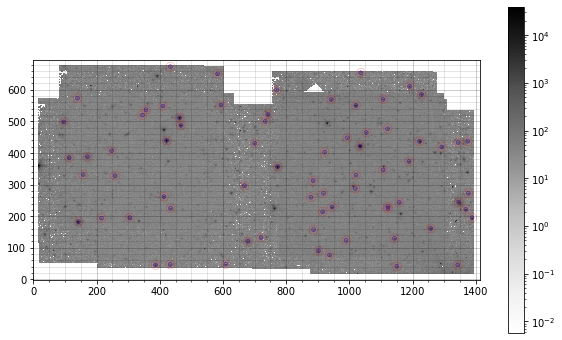

In [5]:
#daofind = DAOStarFinder(threshold=20.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5)
daofind = DAOStarFinder(threshold=50.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5, sharphi = 0.7)
sources = daofind(data)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.75)
annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_bigbig.png', dpi=500)

print(len(sources))

### Aperture photometry:

In [6]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1150.0528 41.601753      20206.612      25412.815
  2 386.74295 45.458175      44326.399            nan
  3  1343.023 45.681609      22347.625      36337.049
  4  432.7817 46.887401      13971.121            nan
  5 609.12078  48.03322      15052.629            nan
  6 937.06686  77.30249      15540.908      22569.242
  7 901.59729 90.255708      34061.296      32349.948
  8 678.04896 120.67174      44819.746      41595.659
  9 989.44944 123.26729      15747.113      25742.513
 10 1142.6191 129.77561      39614.985      28835.324
...       ...       ...            ...            ...
 62 593.19629 551.79662      28754.326       27413.37
 63 942.60339 569.13864      33203.326      31838.544
 64 1106.5571 569.69594      24538.208      25181.997
 65 139.22387 573.41217      15299.924      25394.047
 66 1228.0371 585.49859     

In [7]:
annulus_masks = annuli.to_mask(method='center')
aperture_correction = 1.125

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_annuli, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_annuli)
    
bkg_median = np.array(bkg_median)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = aperture_correction * (phot_table['aperture_sum_0'] - phot_table['aper_bkg'])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1150.0528 41.601753 ...      48.400345   5473.95       16574.245
  2 386.74295 45.458175 ...      48.895529  5529.954           43646
  3  1343.023 45.681609 ...      71.277359 8061.2794       16072.139
  4  432.7817 46.887401 ...      42.088205 4760.0639       10362.439
  5 609.12078  48.03322 ...      37.512127 4242.5216       12161.371
  6 937.06686  77.30249 ...      44.973366 5086.3678       11761.358
  7 901.59729 90.255708 ...      61.189175 6920.3326       30533.584
  8 678.04896 120.67174 ...      71.793732 8119.6798       41287.574
  9 989.44944 123.26729 ...      50.238438 5681.8334       11323.439
 10 1142.6191 129.77561 ...      54.937679 6213.3051        37576.89
...       ...       ... ...            ...       ...             ...
 62 593.19629 551.79662 ...      5

### Building an ePSF:

In [8]:
cutout_size = 150
#cutout_size = 200    # this whole bit might not work properly, since the image doesn't go all the way to the edges of the graph
hsize = (cutout_size - 1) / 2
x = phot_table['xcenter'].value
y = phot_table['ycenter'].value
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_table = Table()
star_table['x'] = x[mask]
star_table['y'] = y[mask]

print(star_table)

        x                  y         
------------------ ------------------
  937.066861872341  77.30248956008053
 901.5972882006813  90.25570810818085
 678.0489555503532 120.67173715491315
 989.4494416136453 123.26729416728504
 1142.619144550548 129.77560803303803
 720.2079852237532  132.4634003379652
 886.5136638634381 157.47588822613324
1257.6453165202408  161.2171090069056
142.19432813484437 182.50833453494593
215.22884283443284  193.9603818908758
               ...                ...
 741.8625042922374  522.2113791978954
 356.2888339994994  537.0892547547545
410.05105267288764  548.4659404044584
 1020.404234995659  550.5950152353512
  593.196291829272  551.7966177588476
 942.6033913695115  569.1386413706331
 1106.557059747372  569.6959363567099
139.22386938053972   573.412172401078
1228.0370975029273  585.4985914130496
 769.4841767686548  599.9041351757072
1190.5967492547368  611.1096900817679
Length = 57 rows


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


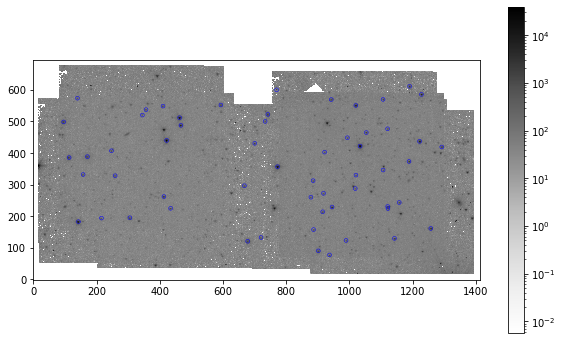

In [9]:
starpos = np.transpose((star_table['x'], star_table['y']))
starap = CircularAperture(starpos, r=6.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5)
plt.gcf().set_size_inches(10, 6)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


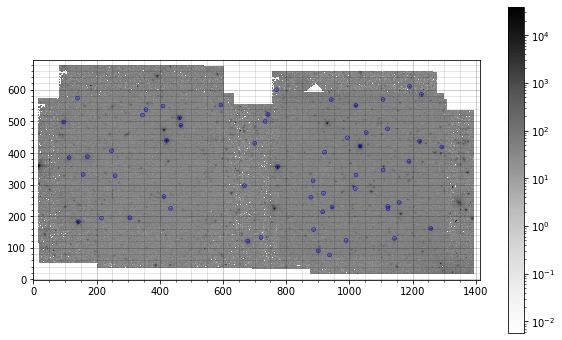

In [10]:
_, median_sub, _ = sigma_clipped_stats(data, sigma=6.) # could use 'median' as above if keeping same sigma

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5, alpha=1.)
#annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_subdata.png', dpi=500)

7 8 1 57


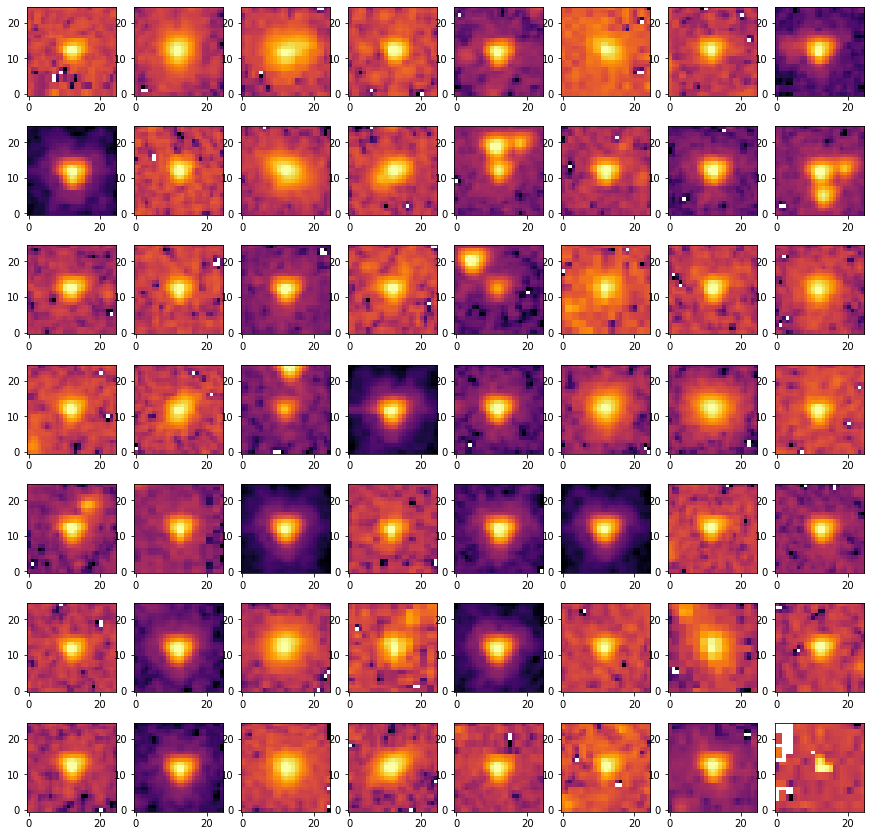

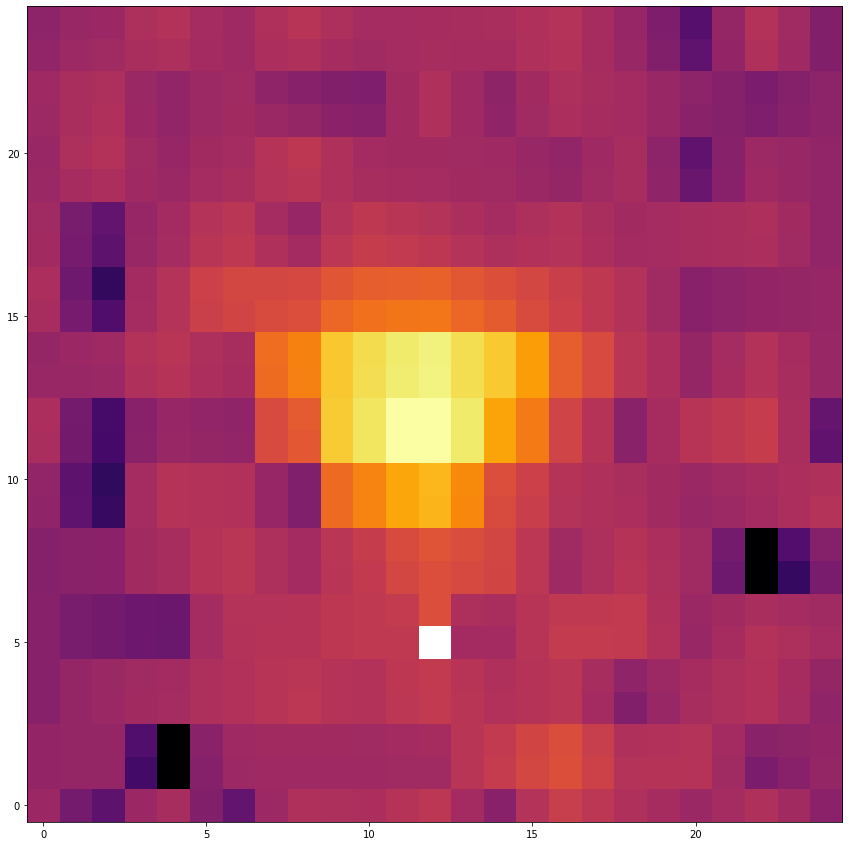

In [12]:
data_sub = data - median_sub

#nddata = NDData(data = data)
nddata = NDData(data = data_sub)
stars = extract_stars(nddata, star_table, size=25)
ncols = 8
nrows = int(np.floor(len(stars) / ncols))
nrem = len(stars) - (nrows*ncols)
print(nrows, ncols, nrem, len(stars))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=nrem, figsize=(15, 15), squeeze=False)
ax = ax.ravel()
for i in range(nrows*ncols, len(stars)):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i - nrows*ncols].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
plt.show()

#fig, ax = plt.subplots(nrows=1, ncols=nrem, figsize=(15, 15), squeeze=True)
#ax = ax.ravel()
#for i in range(nrows*ncols + 1, len(stars)):
#    norm = simple_norm(stars[i], 'log', percent=99.)
#    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
#plt.show()

Visualising the ePSF:

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


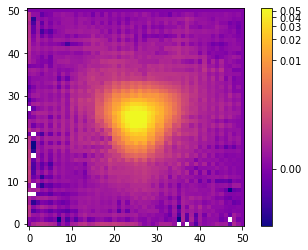

In [13]:
# maxiters = 3 looks good to me, oversampling could either be 3 or 4 (unless we want original resolution)
epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma')
#plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma', vmin=0.01)
plt.colorbar()

### Beginning PSF photometry:

Re-doing source detection to find more stars:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


530


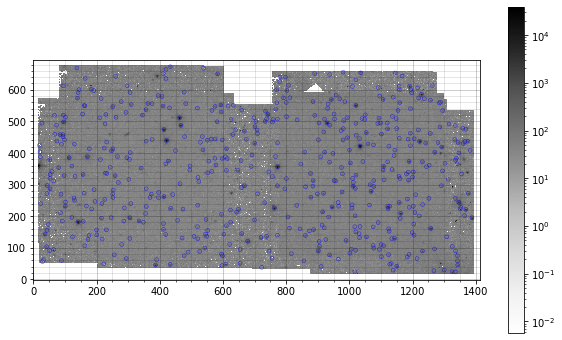

In [14]:
daofind_PSF = DAOStarFinder(threshold=6.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5, sharphi = 0.8) # could use a sigma*gaussian_sigma_to_fwhm instead (see PSF tutorial)
sources_PSF = daofind_PSF(data)

pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
apertures_PSF = CircularAperture(pos_PSF, r=6.)
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures_PSF.plot(color='blue', lw=.5, alpha=.75)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

plt.savefig('images/psf_01.png', dpi=500)
print(len(sources_PSF))

Grouping stars based on proximity to neighbours:

In [15]:
sources_PSF['xcentroid'].name = 'x_0'
sources_PSF['ycentroid'].name = 'y_0'

fwhm = 5.   # loosely determined using imexam with several stars
daogroup = DAOGroup(crit_separation = 2.5 * fwhm) # from tests, 2.5 - 3ish looks decent; groups stars roughly one aperture apart
star_groups = daogroup(sources_PSF)
star_groups = star_groups.group_by('group_id')
print(star_groups)

 id        x_0                y_0         ...         mag          group_id
--- ------------------ ------------------ ... -------------------- --------
  1 1335.7201430054681 23.327156285941737 ... -0.15871747959254623        1
  3 1325.4233008042218 24.020858199543113 ...  -3.7943630032883076        1
  2 1017.0720463541089 24.456138915509573 ... -0.01603570351343244        2
  4 1267.5653110068354  27.53139597923031 ...  -1.1302419903278833        3
  5  1138.372310856092   28.9909116696832 ...  -0.7342172172015669        4
  6 1300.2369548172585 29.593041805458693 ...   -1.605750159529655        5
  7  722.2239317280282  37.94325844489843 ... -0.07381646971528949        6
  8  910.4856115760876   40.6448202714618 ...  -0.2606826134613617        7
  9 1150.0528392708088 41.601753304811524 ...  -2.4594585393114645        8
 10  596.7655799588732 43.768450277750745 ...  -1.3250645103862413        9
...                ...                ... ...                  ...      ...
520  937.418

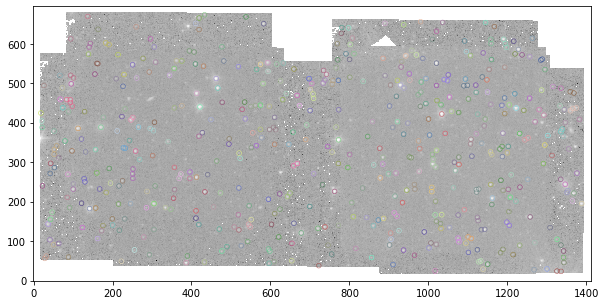

In [16]:
ncolors = max(star_groups['group_id'])
cmap = make_random_cmap(ncolors=ncolors, seed=1612)

plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys_r')
for i, group in enumerate(star_groups.groups):
    pos_group = np.transpose([group['x_0'], group['y_0']])
    ap_group = CircularAperture(pos_group, r=6.)
    ap_group.plot(color=cmap.colors[i], lw=.5)
    
plt.savefig('images/groups_test_03.png', dpi=500)
plt.gcf().set_size_inches(10, 6)
plt.show()

Replacing all NaNs with a float:

(695, 1413)


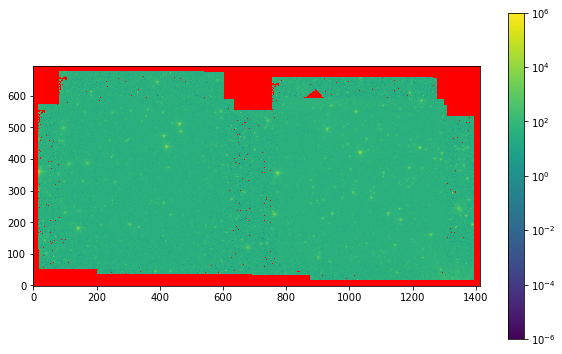

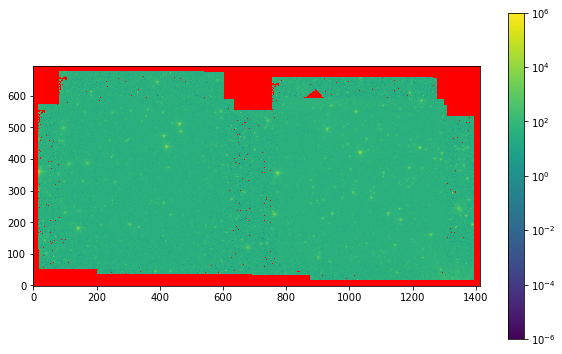

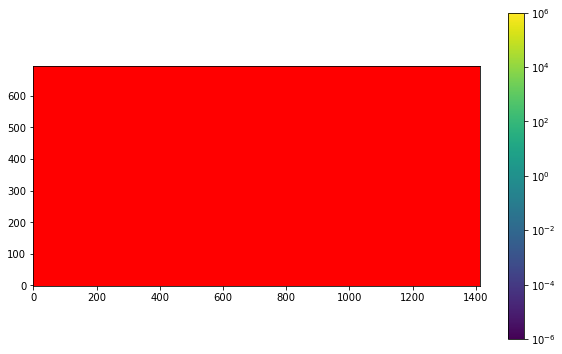

[[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 ...
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [17]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

test = np.nan_to_num(data, nan=0.00001, copy=True)
print(test.shape)
plt.imshow(test, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

plt.imshow(data - test, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

print(test[0:50, 0:50])
print(data[0:50, 0:50])
print(data[0:50, 0:50] - test[0:50, 0:50])

***psf_model***: 'epsf' should already be in right format (EPSFModel class) for ISPSF, see very bottom of photutils' ePSF page

***aperture_radius***: need to specify, as FWHM probably can't be found from ePSF (could try as 6pix like central apertures, or the same as FWHM, 5pix)

In [18]:
epsf.x_0.fixed = True
epsf.y_0.fixed = True
init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])

In [19]:
bkg_estimation = MMMBackground()  # same as SKY in DAOPHOT; ie. the mode of the bkg
fitter = LevMarLSQFitter()
fit_rad = 5

start = time.perf_counter()
PSF_photometry = ISPSF(finder = daofind_PSF,
                      group_maker = daogroup,
                      bkg_estimator = bkg_estimation,
                      psf_model = epsf,
                      fitter = fitter,
                      fitshape = 2*fit_rad+1,   # eg. 13 -> fits at pixels -6,-5,...,5,6 in x and y
                      niters = 10,
                      aperture_radius = 6.)  
result = PSF_photometry(image = test, init_guesses=init_pos)
residual_image = PSF_photometry.get_residual_image()
print('Time taken: {}s'.format(time.perf_counter() - start))

#print(fit_info['message'])

Time taken: 17.60680650000006s


In [20]:
result

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,iter_detected
float64,float64,float64,int32,int32,float64,float64,float64,float64,int32
1335.7201430054681,23.327156285941737,5863.0942736928055,1,1,1335.7201430054681,23.327156285941737,2488.45865501414,802.8037585169494,1
1325.4233008042218,24.020858199543113,22475.128830907022,3,1,1325.4233008042218,24.020858199543113,27190.670284859734,819.2846431015438,1
1017.0720463541089,24.456138915509573,-434.09933611251506,2,2,1017.0720463541089,24.456138915509573,409.5914822659328,102.47348541902899,1
1267.5653110068354,27.53139597923031,4327.476105677626,4,3,1267.5653110068354,27.53139597923031,3059.1334430264897,138.9057024625595,1
1138.372310856092,28.9909116696832,2891.971047381873,5,4,1138.372310856092,28.9909116696832,2188.6074266049995,95.38095954970838,1
1300.2369548172585,29.593041805458693,9218.751081719385,6,5,1300.2369548172585,29.593041805458693,5019.819035966491,329.9231256166675,1
722.2239317280282,37.94325844489843,-1635.9724968248602,7,6,722.2239317280282,37.94325844489843,91.80655852545374,154.04223558400514,1
910.4856115760876,40.6448202714618,875.8163643566074,8,7,910.4856115760876,40.6448202714618,1136.7278788695228,69.88371117731067,1
1150.0528392708088,41.601753304811524,14948.70098535787,9,8,1150.0528392708088,41.601753304811524,11230.703667107273,292.87897118586045,1


In [21]:
#print(self.fit_info['message'])

In [22]:
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])
#hdul.writeto('outputs/residual_01.fits', overwrite=True)

print(residual_image[0:100, 0:100])

[[-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 [-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 [-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 ...
 [-46.490128   -46.490128   -46.490128   ...  -0.82084274  -3.61232
   -8.335728  ]
 [-46.490128   -46.490128   -46.490128   ...  14.287533    12.248028
   -6.709484  ]
 [-46.490128   -46.490128   -46.490128   ...  10.286182     8.2271
   -2.6662483 ]]


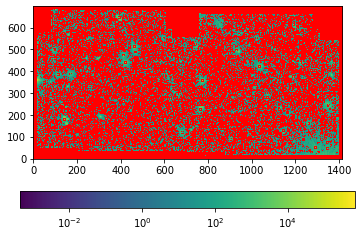

In [23]:
res_file = 'outputs/residual_01.fits'
res_data = fits.getdata(res_file, ext=0)
plt.imshow(res_data, cmap='viridis', origin='lower', norm=LogNorm(), interpolation='nearest')
plt.colorbar(orientation='horizontal')

Viewing the residual image:

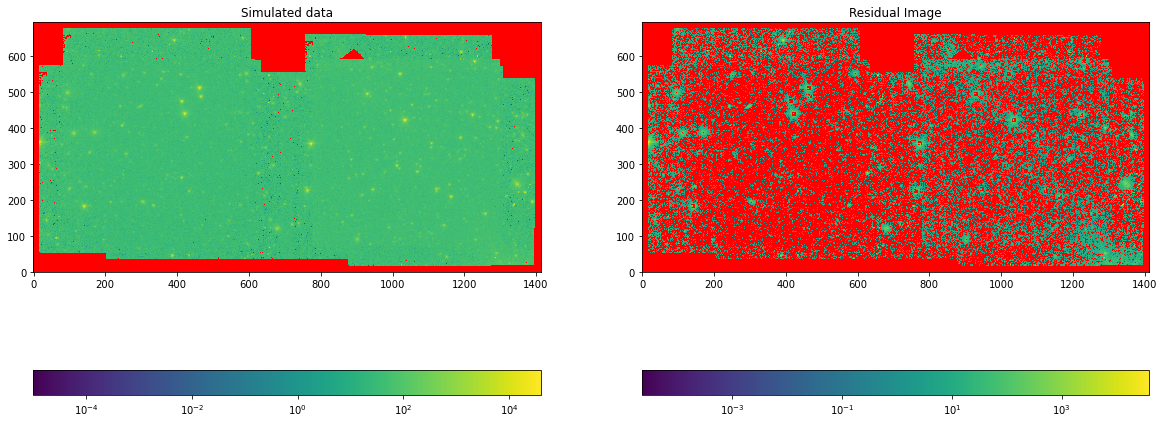

In [24]:
current_cmap = matplotlib.cm.get_cmap()
#current_cmap = 'viridis'
current_cmap.set_bad(color='red')

plt.subplot(1, 2, 1)
plt.imshow(test, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Simulated data')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(20, 12)
#plt.show()

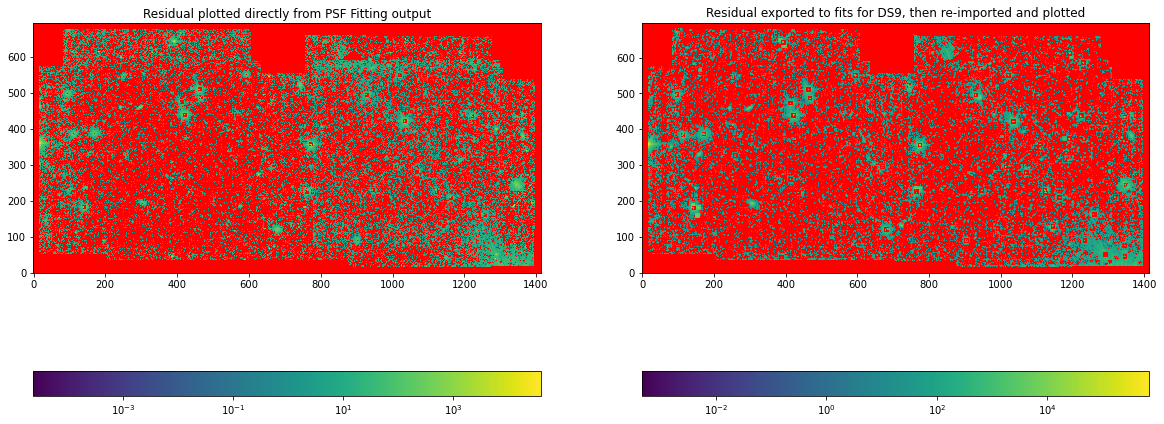

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(residual_image, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual plotted directly from PSF Fitting output')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(res_data, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual exported to fits for DS9, then re-imported and plotted')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(20, 12)
plt.savefig('images/residual_bastards.png', dpi=200)

In [26]:
print(result['id', 'group_id', 'iter_detected', 'x_0', 'y_0'])
print(result['flux_0', 'x_fit', 'y_fit', 'flux_fit'])

 id group_id iter_detected        x_0                y_0        
--- -------- ------------- ------------------ ------------------
  1        1             1 1335.7201430054681 23.327156285941737
  3        1             1 1325.4233008042218 24.020858199543113
  2        2             1 1017.0720463541089 24.456138915509573
  4        3             1 1267.5653110068354  27.53139597923031
  5        4             1  1138.372310856092   28.9909116696832
  6        5             1 1300.2369548172585 29.593041805458693
  7        6             1  722.2239317280282  37.94325844489843
  8        7             1  910.4856115760876   40.6448202714618
  9        8             1 1150.0528392708088 41.601753304811524
 10        9             1  596.7655799588732 43.768450277750745
...      ...           ...                ...                ...
 13        7            10  757.0466535608507   607.632751145051
 14        7            10  757.0543827451551  614.0726826092576
 16        7            1

257


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


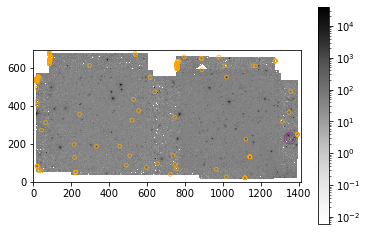

In [27]:
negatives = []
fail_x_0 = []
fail_y_0 = []
fail_x_fit = []
fail_y_fit = []

for i in range(len(result)):
    if result['flux_0'][i] < 0.:
        negatives.append(result['flux_0'][i])
        fail_x_0.append(result['x_0'][i])
        fail_y_0.append(result['y_0'][i])
    elif result['flux_fit'][i] < 0.:
        fail_x_fit.append(result['x_fit'][i])
        fail_y_fit.append(result['y_fit'][i])

#print(negatives)
print(len(negatives))

fails_0 = np.column_stack((fail_x_0, fail_y_0))
fails_fit = np.column_stack((fail_x_fit, fail_y_fit))
bad_apples_0 = CircularAperture(fails_0, r=10.)
bad_apples_fit = CircularAnnulus(fails_fit, r_in=20., r_out=30.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
bad_apples_0.plot(color='orange', lw=.7, alpha=1.)
bad_apples_fit.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/psf_fails_01.png', dpi=500)

In [28]:
def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

In [29]:
file_corr = 'data/PAL5/PAL5__e1/PAL5__e1_correction_3p6um.fits'
with fits.open(file_corr) as hdu_list:
    data_corr = hdu_list[0].data

In [34]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
zmag_err = 0.02
apcorr = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
apcorr_err = 0.0225
conv = fluxconv / exptime
negative_sums = []

result['apparent_mag'] = float('NaN')
result['mag_err'] = float('NaN')

for i in range(0, len(result)):
    locorr = data_corr[int(result['y_fit'][i])][int(result['x_fit'][i])]
    if result['flux_fit'][i] >= 0:
        result['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * conv * result['flux_fit'][i])
        result['mag_err'][i] = apparent_magnitude_err(result['flux_fit'][i], apcorr, zmag_err, result['flux_unc'][i], apcorr_err)
    else:
        negative_sums.append(result['id'][i])

for col in result.colnames:
    result[col].info.format = '%.8g'
print(result['id', 'x_0', 'y_0', 'flux_fit', 'apparent_mag', 'mag_err'])
#print(negative_sums)

print(np.count_nonzero(~np.isnan(result['apparent_mag'])))

 id    x_0       y_0       flux_fit    apparent_mag   mag_err   
--- --------- --------- -------------- ------------ ------------
  1 1335.7201 23.327156      2488.4587     17.06778   0.35151216
  3 1325.4233 24.020858       27190.67    14.471556  0.044065434
  2  1017.072 24.456139      409.59148    19.026729   0.27323401
  4 1267.5653 27.531396      3059.1334     16.84361  0.057463107
  5 1138.3723 28.990912      2188.6074    17.207187  0.055771295
  6  1300.237 29.593042       5019.819    16.305886  0.077224622
  7 722.22393 37.943258      91.806559    20.650422    1.8219961
  8 910.48561  40.64482      1136.7279    17.918465  0.072985874
  9 1150.0528 41.601753      11230.704    15.431589  0.040905107
 10 596.76558  43.76845      2901.4367    16.901073  0.048827989
...       ...       ...            ...          ...          ...
 13 757.04665 607.63275 -1.4913548e-05          nan          nan
 14 757.05438 614.07268 -1.6813749e-05          nan          nan
 16 757.11387 623.98908  

In [ ]:
#plt.hist(result['apparent_mag'], bins=200)

In [ ]:
#result['id', 'x_0', 'y_0', 'apparent_mag'].write('outputs/psf_test01.txt', format='csv', overwrite=True)